In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from PDE_solver_backend import Aggregate,PDESolver
from PDE_solver_backend_laplace import PDESolverLaplace
from random import shuffle

In [3]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

def make_points_line(N,which_axis,fixed_value,range_other,nugget=1e-5):
    assert which_axis in {'x','y'}
    X=np.zeros((N,2))
    num_axis=int(which_axis=='y')
    X[:,num_axis]=fixed_value
    X[:,1-num_axis]=np.linspace(range_other[0]+nugget,range_other[1]-nugget,N)
    return X

def make_points_on_specific_boundary(Nb,which_axis,which_side,range_model=np.array([-1,1])):
    assert which_axis in {'x','y'}
    assert which_side in {-1,1}
    assert range_model.shape==(2,) and range_model[1]-range_model[0]>=0
    X=np.zeros((Nb,2))
    num_axis=int(which_axis=='y')
    X[:,num_axis]=which_side
    X[:,1-num_axis]=np.random.rand(Nb)*(range_model[1]-range_model[0])+range_model[0]
    return X

def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def dumb_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model(x[which_model==i])
    return res

def laplacian_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model.laplacian(x[which_model==i])
    return res



In [4]:
from sympy import cos,sin,pi,symbols,diff,lambdify,exp

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=exp(-x+y)*cos(pi*x*y)#cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=-laplacian(u_symbolic)+u_symbolic**3
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.power(x,3)
dtau=lambda x:3*x**2
#tau=lambda x:np.zeros_like(x)
#dtau=lambda x:np.zeros_like(x)
f_symbolic

-(-pi**2*x**2*cos(pi*x*y) - 2*pi*x*sin(pi*x*y) + cos(pi*x*y))*exp(-x + y) - (-pi**2*y**2*cos(pi*x*y) + 2*pi*y*sin(pi*x*y) + cos(pi*x*y))*exp(-x + y) + exp(-3*x + 3*y)*cos(pi*x*y)**3

In [25]:
dxu_tuple=lambdify((x,y),diff(u_symbolic,x))
dxu=lambda xy:dxu_tuple(xy[0],xy[1])
dyu_tuple=lambdify((x,y),diff(u_symbolic,y))
dyu=lambda xy:dyu_tuple(xy[0],xy[1])

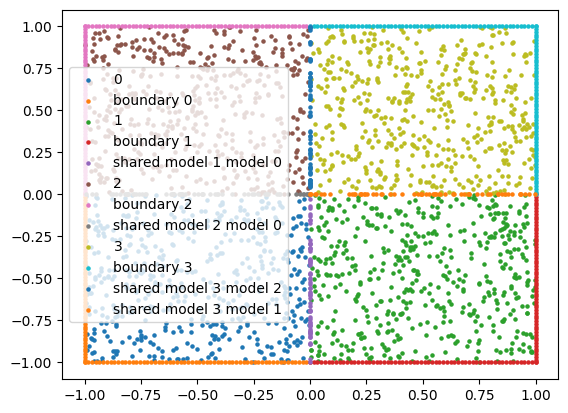

In [82]:
int_point_number=2000
ext_point_number=1000
width=2
int_point_per_model=int_point_number//width**2
ext_point_per_model=ext_point_number//width**2

sigma=0.1
boundary_width=0

models=[]
laplace_models=[]
for i in range(width**2):
    ext_point_per_model=ext_point_number//width**2
    yi=i//width
    xi=i%width
    range_model=np.array([
        [-1+2*xi/width,-1+2*(xi+1)/width],
        [-1+2*yi/width,-1+2*(yi+1)/width]
    ])
    X_int=make_points_inside(int_point_per_model,range_model)
    X_bounds=[]
    if i%width==0:
        X_bounds.append(make_points_line(ext_point_per_model//4,'x',-1,[-1+2*yi/width,-1+2*(yi+1)/width]))
    if i%width==width-1:
        X_bounds.append(make_points_line(ext_point_per_model//4,'x',1,[-1+2*yi/width,-1+2*(yi+1)/width]))
    if i//width==0:
        X_bounds.append(make_points_line(ext_point_per_model//4,'y',-1,[-1+2*xi/width,-1+2*(xi+1)/width]))
    if i//width==width-1:
        X_bounds.append(make_points_line(ext_point_per_model//4,'y',1,[-1+2*xi/width,-1+2*(xi+1)/width]))

    plt.scatter(X_int[:,0],X_int[:,1],label=f'{i}',s=5)

    try:
        X_boundary=np.concatenate(X_bounds)
        plt.scatter(X_boundary[:,0],X_boundary[:,1],label=f'boundary {i}',s=5)
    except ValueError:
        X_boundary=np.empty((0,2))
    
    models.append(
        PDESolver(
            X_int=X_int,
            X_boundary=X_boundary,
            sigma=sigma,
            name=f'model {i}')
    )
    laplace_models.append(
        PDESolverLaplace(
            X_int=X_int,
            X_boundary=X_boundary,
            sigma=sigma,
            name=f'model laplace {i}')
    )
    #ext_point_per_model=4
    if i%width>0:
        range_neighbors=np.array([
            [-1+2*xi/width-boundary_width,-1+2*xi/width+boundary_width],
            [-1+2*yi/width,-1+2*(yi+1)/width]
        ])
        #X_shared=make_points_line(ext_point_per_model//4,'x',-1+2*xi/width,[-1+2*yi/width,-1+2*(yi+1)/width])
        X_shared=make_points_inside(ext_point_per_model//4,range_neighbors)
        models[-1].add_neighbors([models[-2]], [X_shared])
        models[-2].add_neighbors([models[-1]], [X_shared])
        laplace_models[-1].add_neighbors([laplace_models[-2]], [X_shared])
        laplace_models[-2].add_neighbors([laplace_models[-1]], [X_shared])
        plt.scatter(X_shared[:,0],X_shared[:,1],label=f'shared {models[-1]} {models[-2]}',s=5)
    if i//width>0:
        range_neighbors=np.array([
            [-1+2*xi/width,-1+2*(xi+1)/width],
            [-1+2*yi/width-boundary_width,-1+2*(yi)/width+boundary_width]
        ])
        X_shared=make_points_inside(ext_point_per_model//4,range_neighbors)
        #X_shared=make_points_line(ext_point_per_model//4,'y',-1+2*yi/width,[-1+2*xi/width,-1+2*(xi+1)/width])
        models[-1].add_neighbors([models[-1-width]], [X_shared])
        models[-1-width].add_neighbors([models[-1]], [X_shared])
        laplace_models[-1].add_neighbors([laplace_models[-1-width]], [X_shared])
        laplace_models[-1-width].add_neighbors([laplace_models[-1]], [X_shared])
        plt.scatter(X_shared[:,0],X_shared[:,1],label=f'shared {models[-1]} {models[-1-width]}',s=5)

plt.legend()
plt.show()

In [78]:
models[0].real_u=real_u
models[0].dx=dxu
models[0].dy=dyu

In [83]:
PDESolver.joint_fit(models,f,real_u,tau,dtau,tol=1e-6)

Current residual 2.805e-07: : 46it [00:12,  3.64it/s]


In [45]:
models[0].shared_value

{model 1: {'dirac': array([0.80251834]),
  'dx': array([-0.80251834]),
  'dy': array([0.80251834])},
 model 2: {'dirac': array([1.516293]),
  'dx': array([-1.516293]),
  'dy': array([1.516293])}}

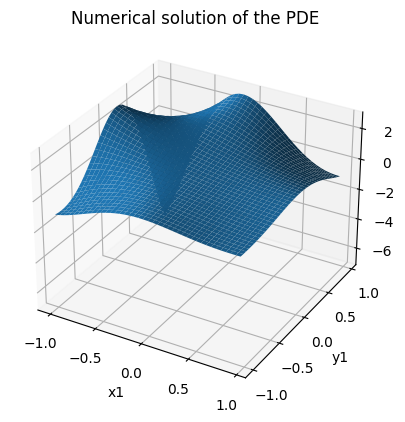

In [84]:
local_aggregate=partial(dumb_aggregate,models=models,width=width)
fig=plot_vectorized_function(local_aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

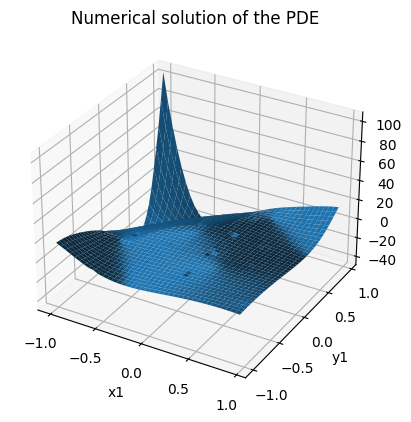

In [20]:
local_laplacian=partial(laplacian_aggregate,models=models,width=width)
fig=plot_vectorized_function(local_laplacian,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [60]:
for model in models:
    model.a = np.concatenate(
        [np.array([real_u(xy) for xy in model.X_shared[n]]) for n in model.neighbors]
        + [model.g_vec]
        + [np.array([real_u(xy) for xy in model.X_int])]
        + [np.array([dxu(xy) for xy in model.X_shared[n]]) for n in model.neighbors]
        + [np.array([dyu(xy) for xy in model.X_shared[n]]) for n in model.neighbors]
        + [model.f_vec-np.array([real_u(xy) for xy in model.X_int])**3]
    )
    model.coeff = model.K_inv @ model.a

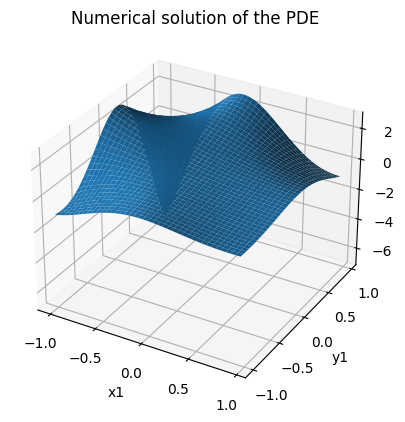

In [61]:
local_aggregate=partial(dumb_aggregate,models=models,width=width)
fig=plot_vectorized_function(local_aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [21]:
print(1/0)

ZeroDivisionError: division by zero

Current residual 2.432e-08: : 6it [00:00, 44.51it/s]
Current residual 3.354e-08: : 4it [00:00, 88.30it/s]
Current residual 1.511e-07: : 4it [00:00, 76.43it/s]
Current residual 2.987e-09: : 4it [00:00, 78.33it/s]
Current residual 2.923e-07: : 3it [00:00, 92.54it/s]
Current residual 1.587e-07: : 8it [00:00, 85.78it/s]
Current residual 6.920e-08: : 3it [00:00, 75.85it/s]
Current residual 1.445e-08: : 2it [00:00, 69.07it/s]
Current residual 3.562e-08: : 2it [00:00, 66.69it/s]
Current residual 4.236e-09: : 4it [00:00, 73.91it/s]
Current residual 8.548e-08: : 8it [00:00, 66.66it/s]
Current residual 2.701e-08: : 4it [00:00, 98.62it/s]
Current residual 2.051e-08: : 2it [00:00, 89.77it/s]
Current residual 2.011e-08: : 2it [00:00, 94.08it/s]
Current residual 2.143e-07: : 4it [00:00, 83.77it/s]
Current residual 1.072e-07: : 10it [00:00, 85.68it/s]
Current residual 6.831e-07: : 6it [00:00, 51.05it/s]
Current residual 1.695e-08: : 4it [00:00, 95.30it/s]
Current residual 6.051e-08: : 3it [00:00, 98.

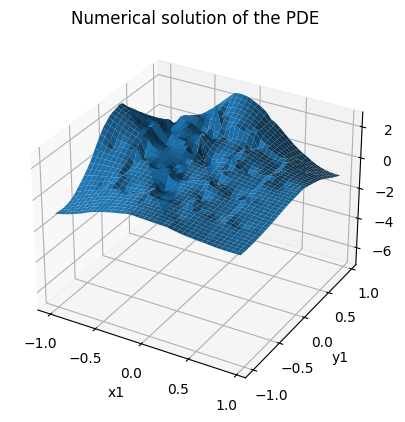

Current residual 4.968e-07: : 3it [00:00, 83.47it/s]
Current residual 1.731e-10: : 3it [00:00, 66.11it/s]
Current residual 6.074e-07: : 3it [00:00, 71.12it/s]
Current residual 2.951e-08: : 5it [00:00, 76.07it/s]
Current residual 2.637e-08: : 5it [00:00, 75.27it/s]
Current residual 5.062e-07: : 3it [00:00, 28.83it/s]
Current residual 1.018e-07: : 4it [00:00, 73.20it/s]
Current residual 3.156e-07: : 3it [00:00, 72.51it/s]
Current residual 4.730e-08: : 5it [00:00, 73.85it/s]
Current residual 2.023e-07: : 4it [00:00, 73.51it/s]
Current residual 4.762e-08: : 5it [00:00, 76.86it/s]
Current residual 7.400e-07: : 3it [00:00, 51.19it/s]
Current residual 1.191e-08: : 4it [00:00, 70.41it/s]
Current residual 2.382e-09: : 4it [00:00, 48.02it/s]
Current residual 3.098e-07: : 4it [00:00, 67.06it/s]
Current residual 2.442e-08: : 6it [00:00, 40.69it/s]
Current residual 1.093e-08: : 4it [00:00, 28.32it/s]
Current residual 1.079e-07: : 4it [00:00, 68.21it/s]
Current residual 1.390e-07: : 5it [00:00, 71.7

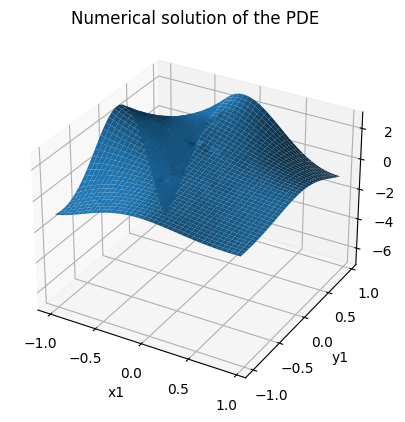

In [20]:
for model in models:
    model.fit_interior(f,real_u,tau,dtau,use_shared=False,nugget=1e-5)
PDESolver.joint_fit_boundaries(models)
local_aggregate=partial(dumb_aggregate,models=models,width=width)
fig=plot_vectorized_function(local_aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()
for i in tqdm(range(10)):
    indexes=[k for k in range(len(models))]
    shuffle(indexes)
    for j in indexes:
        models[j].fit_interior(f,real_u,tau,dtau,use_shared=True,nugget=1e-5)
    PDESolver.joint_fit_boundaries(models)
local_aggregate=partial(dumb_aggregate,models=models,width=width)
fig=plot_vectorized_function(local_aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()


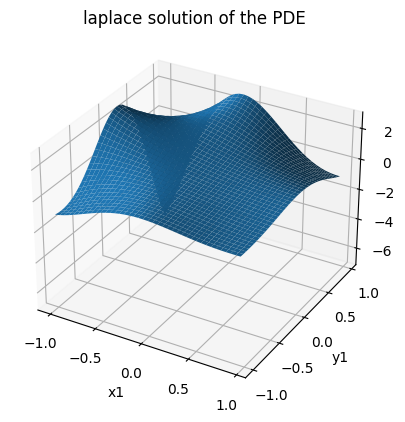

In [ ]:
fig=plot_function(real_u)
plt.title('laplace solution of the PDE')
plt.show()

In [ ]:
'''for model,laplace_clone in zip(models,laplace_models):
    laplace_clone.setup_fit(f, real_u, 1e-5)
    target= np.concatenate(
        [
            model.g_vec,
            model.f_vec,
        ]
    )
    laplace_clone.target_values=target'''
PDESolverLaplace.joint_fit(laplace_models,f,real_u)

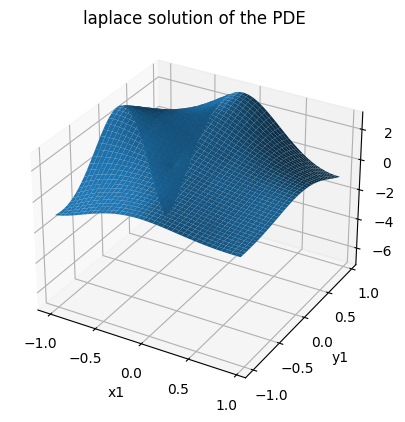

In [ ]:
laplace_aggregate=partial(dumb_aggregate,models=laplace_models,width=width)
fig=plot_vectorized_function(laplace_aggregate,0.05)
plt.title('laplace solution of the PDE')
plt.show()

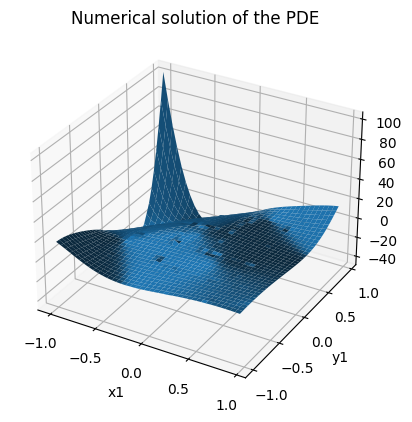

In [ ]:
local_laplacian=partial(laplacian_aggregate,models=models,width=width)
fig=plot_vectorized_function(local_laplacian,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

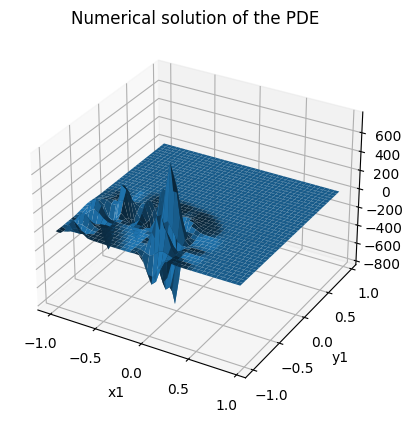

In [ ]:
fig=plot_vectorized_function(models[1].laplacian,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

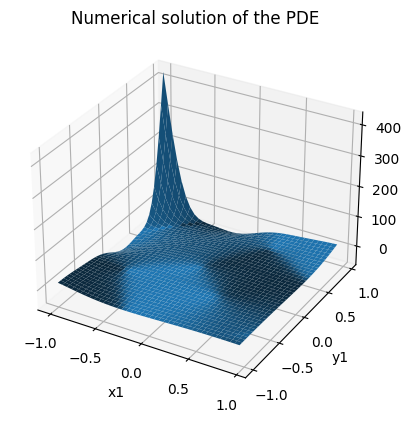

In [ ]:
local_laplacian=partial(laplacian_aggregate,models=models,width=width)
fig=plot_function(lambda x:-f(x)+real_u(x))
plt.title('Numerical solution of the PDE')
plt.show()

In [ ]:
models[0].gauss_newton_solution['z']

array([-1.02090996, -0.70081468, -0.50063122,  0.0060033 , -0.28756736,
       -0.67731608,  0.14797689, -0.0460115 , -0.86585361, -0.38398141,
       -0.73108706, -0.00494593, -0.5026348 , -0.35679262, -0.80518675,
        0.1174634 , -0.57522337, -0.7535536 , -0.66618209, -0.33872511,
        0.17888431, -0.44644856, -0.36955264, -0.63152882, -0.00705201,
        0.1109212 , -0.71314694, -0.92556393,  0.2203712 , -0.65083026,
       -0.27069744, -0.88952602, -0.37039847, -0.83351411, -1.03262687,
       -0.58925735, -0.05362747, -0.28944069, -0.47933985, -0.16125927,
       -0.279297  , -0.88780049, -0.48412942, -0.45040705,  0.23273638,
        0.05154062, -0.02888904, -0.55923189, -0.95693051, -0.53722054,
       -0.09825237, -0.90307031,  0.0194878 ,  0.12000655, -0.96373423,
       -0.26307572, -0.10532315, -0.36039126, -0.81823145, -1.01380275,
       -0.3865864 , -0.22715831, -0.70148056, -0.73259355, -0.62506087,
       -0.11947089,  0.02877858, -0.12810184, -0.20907494,  0.12

In [ ]:
PDESolver.joint_fit_boundaries(models)

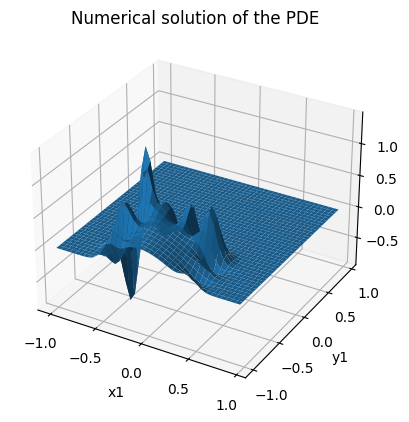

In [ ]:
fig=plot_vectorized_function(models[2],0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [ ]:
models[0].shared_value

{model 1: array([ 0.19267795,  0.34950197, -0.19764892,  0.14107846, -0.04897912,
         0.22403403,  0.1888367 , -0.02466672,  0.15748017,  0.30619904,
        -0.01409558,  0.33982522,  0.29192433,  0.1207835 , -0.14093757,
         0.16131341, -0.00986539,  0.24363674, -0.04321884, -0.14790496,
        -0.02230466,  0.24156295, -0.02255831, -0.10155741,  0.06506665,
         0.23383927,  0.0665013 , -0.02005332,  0.23483127, -0.10765888,
        -0.17061436, -0.12415496,  0.0415318 ,  0.20684492,  0.38481418,
        -0.1999913 ,  0.06582139,  0.35166897,  0.02675643, -0.11045025]),
 model 5: array([-0.34540483, -0.39081639,  0.23841273, -0.28764097, -0.1848833 ,
         0.14696734,  0.25176826,  0.27025045,  0.35530739,  0.30283593,
         0.29730195, -0.13190624, -0.2695244 ,  0.12713832,  0.22865762,
        -0.33146419, -0.02088622,  0.02066748,  0.24731948,  0.3205664 ,
         0.39354017,  0.23128657,  0.05305658,  0.27822562, -0.16393196,
         0.08193238, -0.4183324

In [ ]:
model0=PDESolver(
        X_int=make_points_inside(2000),
        X_boundary=make_points_boundary(500),
        sigma=sigma,
        name=f'model 0')
model0.fit_interior(f,real_u,tau,dtau,use_shared=False,nugget=1e-5)

Current residual 4.629e-09: : 6it [00:17,  2.97s/it]


In [ ]:
model0.a = np.concatenate(
    [
        model0.gauss_newton_solution["z"],
        model0.g_vec,
        model0.gauss_newton_solution["z_lap"],
    ]
)
model0.coeff = model0.K_inv @ model0.a

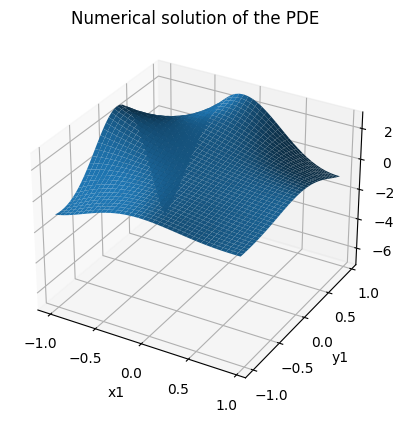

In [ ]:
fig=plot_vectorized_function(model0,0.05)
plt.title('Numerical solution of the PDE')
plt.show()